**Instructors**: Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Jiazhi Li (jiazhil@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Nonlinear Feature Engineering

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from matplotlib import gridspec
import copy
from matplotlib import colors

In [3]:
readDataPath = '../readData/'
generatedDataPath = '../generatedData/'

In [4]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func

def gradient_descent(g,alpha_choice,max_its,w,x,y, sig):
    
    # flatten the input function to more easily deal with costs that have layers of parameters
    g_flat, unflatten, w = flatten_func(g, w) # note here the output 'w' is also flattened

    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w,x,y, sig)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w,x,y, sig))  
    return weight_history,cost_history

- We introduce the general framework of nonlinear regression via the engineering of nonlinear feature transformations, along with many examples ranging from toy datasets to classic examples from differential equations.

###  Modeling principles

The basic linear model for regression as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_{1}w_1 + \cdots + x_{N}w_N
\end{equation}

or more compactly as $\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}$, denoting

$$
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix}\,\,\,\,\,\,\,\,\text{and}
\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=\begin{bmatrix}
1 \\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}
$$

###  Modeling principles of nonlinear regression

- We can move from linear to general *nonlinear* regression by swapping out the linear model $\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_{1}w_1 + \cdots + x_{N}w_N$ with a nonlinear one, for instance a single nonlinear function $f$ that can be parameterized or unparameterized.

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right)  = 
w_0^{\,} + f\left(\mathbf{x}\right){w}_{1}^{\,}
\end{equation}

- In the jargon of machine learning $f$ is often called a nonlinear *feature transformation*.

- Here the set $\Theta$ represents all tunable parameters - both those potentially internal parameters of the function $f$ and those weights in the linear combination. 

As we did in the case of *linear regression*, here we could consider the ideal case - where we have knowledge of the best possible weights so that 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\Theta\right)   \approx y_p
\end{equation}

and to recover our ideal weights we would follow the same logic we used in deriving our cost functions for linear regression.  For example, we could minimize the Least Squares difference between both sides of the above and over all points.

- In general we could create a nonlinear model that is the weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

- Here $f_1,\,f_2,\,...\,f_B$ are nonlinear parameterized or unparameterized functions - or *feature transformations*.

- Once again $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Theta$ and must be tuned properly.

- In analogy to the linear case, here we too can compactly denote the generic nonlinear model by tacking a $1$ on top of the vector of nonlinear feature transformation as

$$
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{B}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{f}}_{\,}=\begin{bmatrix}
1 \\
f_1\left(\mathbf{x}\right)\\
f_2\left(\mathbf{x}\right)\\
\vdots\\
f_B\left(\mathbf{x}\right)
\end{bmatrix}
$$

- With this notation we can write our generic nonlinear model compactly as

$$\text{model}\left(\mathbf{x},\Theta\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}$$


- To tune the parameters of our general nonlinear model we minimize a proper regression cost function over $\Theta$, e.g., the Least Squares cost

\begin{equation}
 g\left(\Theta\right) = \frac{1}{P}\sum_{p=1}^{P} \left(  \mathring{\mathbf{f}}_{p}^T \mathbf{w}   - \overset{\,}{{y}}_{p}^{\,} \right)^2
\end{equation}


### Feature engineering

#### How do we determine the appropriate nonlinear feature transformations for our model, and their number $B$?

- In some simple instances we can determine these by **visualizing the data** and relying on our own pattern recognition abilities to determine the appropriate nonlinearities. 

- This kind of practice is referred to as **nonlinear feature engineering**.

#### <span style="color:#a50e3e;">Example. </span> The linear case

Let us first examine our original linear regression throug the lense of nonlinear feature engineering.   The figure below we shows a low dimensional regression dataset that looks is a clear candidate linear modeling.

In [5]:
data = np.loadtxt(readDataPath + 'unnorm_linregress_data.csv',delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

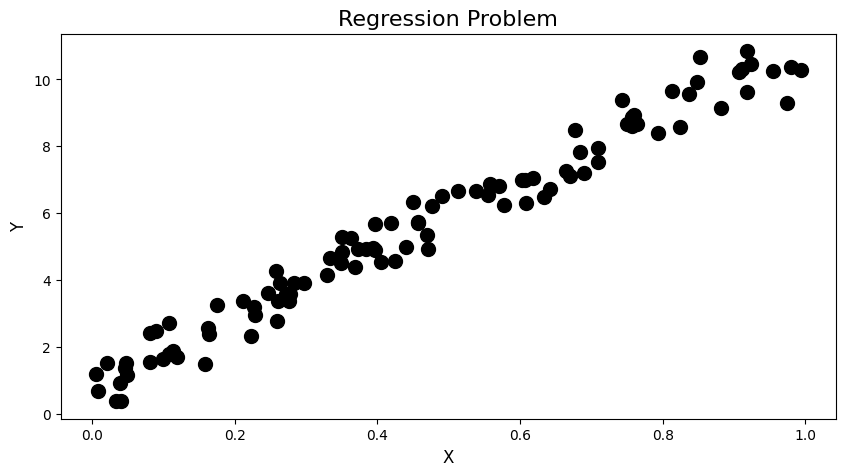

In [6]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Regression Problem', fontsize=16)
plt.show()

Since this data looks quite linear in nature, we would clearly employ a linear model.  In terms of feature engineering, here we employ the simple linear feature transformation

\begin{equation}
f\left(x\right) = x
\end{equation}

and in this notation our linear model is then

\begin{equation}
\text{model}\left(x,\Theta\right) = w_0 +f\left(x\right)w_{1\,}.
\end{equation}

Note how in performing standard normalization (subtracing the mean and dividing off the standard deviation of the input) we can actually think of the normalization as being a part of the feature transformation itself, and write it formally as

\begin{equation}
f\left(x \right) = \frac{x - \mu}{\sigma}
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset's input. 

Below we plot the fit provided by minimizing the Least Squares cost employing this feature transformation.

In [7]:
from inspect import signature

In [8]:
def feature_transforms(x):
    return x

In [9]:
###### cost functions #####
# compute linear combination of input point
def model(x,w,sig):   
    # feature transformation - switch for dealing
    # with feature transforms that either do or do
    # not have internal parameters
    f = 0
    if len(sig.parameters) == 2:
        f = feature_transforms(x,w[0])
    else: 
        f = feature_transforms(x)    

    # compute linear combination and return
    # switch for dealing with feature transforms that either 
    # do or do not have internal parameters
    a = 0
    if len(sig.parameters) == 2:
        a = w[1][0] + np.dot(f.T,w[1][1:])
    else:
        a = w[0] + np.dot(f.T,w[1:])
    return a.T

In [10]:
def least_squares(w,x,y,sig):
    cost = np.sum((model(x,w,sig) - y)**2)
    return cost/float(np.size(y))

In [11]:
w = 0.1*np.random.randn(2,1); max_its = 500; alpha_choice = 10**(-1)

In [12]:
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   
    
    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [13]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

In [14]:
g = least_squares

In [15]:
sig = signature(feature_transforms)

In [16]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, sig)

In [17]:
ind = np.argmin(cost_history)
w_best = weight_history[ind]

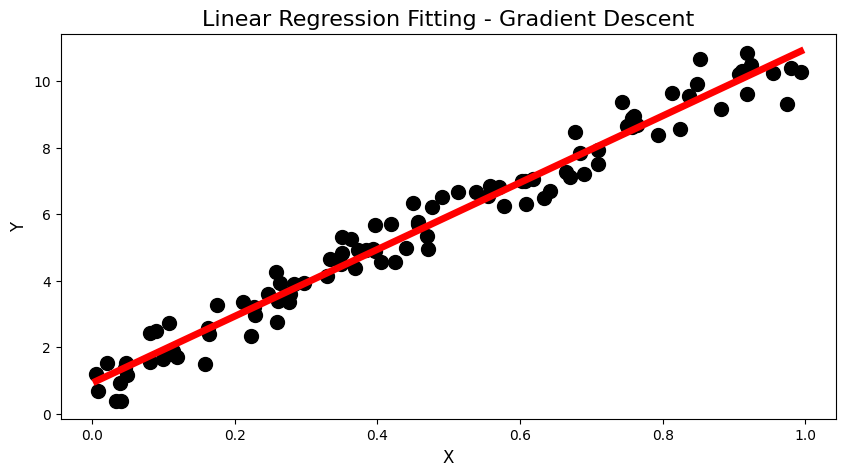

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Linear Regression Fitting - Gradient Descent', fontsize=16)

x_line = np.linspace(min(x[0]),max(x[0]),1000).reshape((1,1000))

y_line = model(normalizer(x_line),w_best, sig)
plt.plot(x_line[0],y_line[0],'r-',linewidth=5)
plt.show()

#### <span style="color:#a50e3e;">Example.</span> Modeling a familiar wave using a parameterized feature transformation

In [19]:
def feature_transforms_sine(x,w):
    # calculate feature transform
    f = np.sin(w[0] + np.dot(x.T,w[1:])).T
    return f

In [20]:
###### cost functions #####
# compute linear combination of input point
def model(x,w,sig):   
    # feature transformation - switch for dealing
    # with feature transforms that either do or do
    # not have internal parameters
    f = 0
    if len(sig.parameters) == 2:
        f = feature_transforms_sine(x,w[0])
    else: 
        f = feature_transforms_sine(x)    

    # compute linear combination and return
    # switch for dealing with feature transforms that either 
    # do or do not have internal parameters
    a = 0
    if len(sig.parameters) == 2:
        a = w[1][0] + np.dot(f.T,w[1][1:])
    else:
        a = w[0] + np.dot(f.T,w[1:])
    return a.T

In [21]:
csvname = readDataPath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

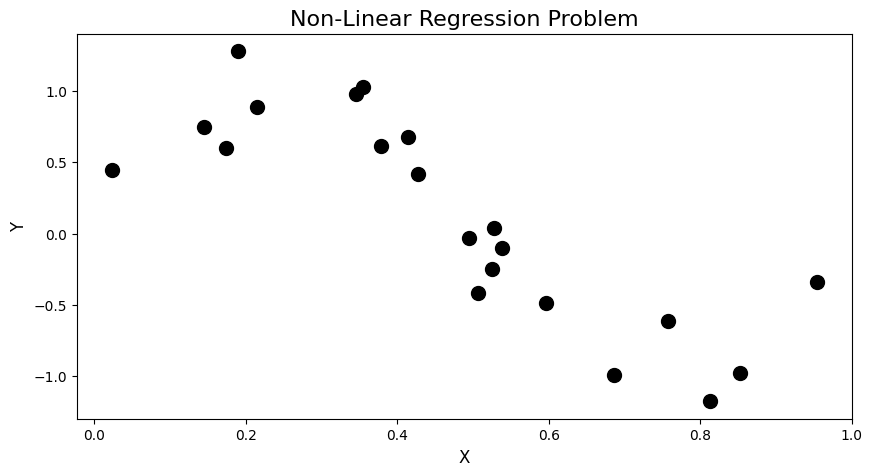

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression Problem', fontsize=16)
plt.show()

This dataset looks sinusoidal, so we can defensibly propose a `model` consisting of completely *parameterized* sinusoidal function or *feature transformation* 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{sin}\left(w_0 + xw_1\right)
\end{equation}

We can then take as our model a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\Theta\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

In [23]:
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 500; alpha_choice = 10**(-1)

In [24]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

In [25]:
g = least_squares

In [26]:
sig = signature(feature_transforms_sine)

In [27]:
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,x,y, sig)

In [28]:
weight_history_2,cost_history_2 = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, sig)

In [29]:
ind = np.argmin(cost_history_2)
w_best = weight_history_2[ind]

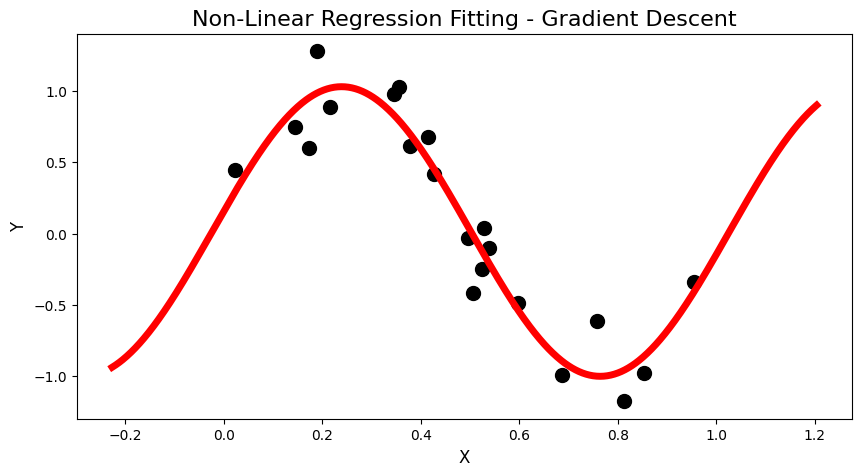

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression Fitting - Gradient Descent', fontsize=16)

x_line = np.linspace(min(x[0]-0.25),max(x[0])+0.25,1000).reshape((1,1000))

y_line = model(normalizer(x_line),w_best, sig)
plt.plot(x_line[0],y_line[0],'r-',linewidth=5)
plt.show()

Notice that since `model` is defined *linearly* in terms of its feature transformation we can represent our transformed input $x_p \longleftarrow f\left(x_p,\mathbf{w}^{\star}\right)$ and the correspnoding model fit $
\text{model}\left(x,\Theta^{\star}\right)$ in what is called the *transformed feature space*.

This is simply the space whose input is the feature transformed input $\,f\left(x_p,\mathbf{w}^{\star}\right)$ and whose output remains as $y$.  

In this space our *nonlinear* fit is a *linear* one. 

- Notice, with our model completely tuned if plot the points $\left(f\left(x_1,\mathbf{w}^{\star}\right),y_1\right),\,\left(f\left(x_2,\mathbf{w}^{\star}\right),y_2\right)...,\left(f\left(x_P,\mathbf{w}^{\star}\right),y_P\right)$ our model fits the transformed data *linearly*.


- This finding is true in general with nonlinear regression problems.

> A properly designed feature (or set of features) provides a good nonlinear fit in the original feature space and, simultaneously, a good linear fit in the transformed feature space.

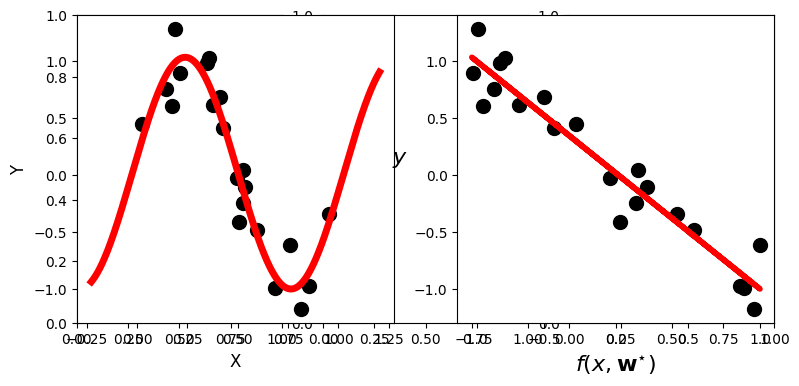

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(9,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 
ax1.scatter(x,y,s=100,facecolors='k', edgecolors='k')
ax1.set_xlabel('X', fontsize = 12)
ax1.set_ylabel('Y', fontsize = 12)

xmin = min(x[0]-0.25); xmax = max(x[0])+0.25;

x_line = np.linspace(xmin,xmax,1000).reshape((1,1000))

y_line = model(normalizer(x_line),w_best, sig)
ax1.plot(x_line[0],y_line[0],'r-',linewidth=5)

x_transformed = feature_transforms_sine(x_normalized,w_best[0])
ax2.scatter(x_transformed,y,s=100,facecolors='k', edgecolors='k')
s = np.linspace(xmin,xmax,300)[np.newaxis,:]
s2 = feature_transforms_sine(normalizer(s),w_best[0])
t = model(normalizer(s),w_best, sig)
ax2.plot(s2.flatten(),t.flatten(),linewidth = 4,c = 'r')
ax2.set_xlabel(r'$f\left(x,\mathbf{w}^{\star}\right)$', fontsize = 16)
ax2.set_ylabel(r'$y$', rotation = 0,fontsize = 16,labelpad = 10)
plt.show()

- Finally note, as with the previous example that we can - and should - employ standard normalization to scale our input here when employing gradient descent to minimize the corresponding Least Squares cost.   

- *Feature scaling* is equally important in the context of nonlinear regression.  Here it also helps temper the contours of any regression cost function making it considerably easier for gradient descent to minimize.  

- Below we show the resulting cost function history resulting from a run of gradient descent employing the original and standard normalized versions of the input.  Comparing the two plots we can see that a significantly lower cost function value was found using the standard-normalized input.  

- Moreover, the convergence behavior displayed by the cost function plot on the original data is actually somewhat deceiving here - it appears to converge but not to a global minimum.

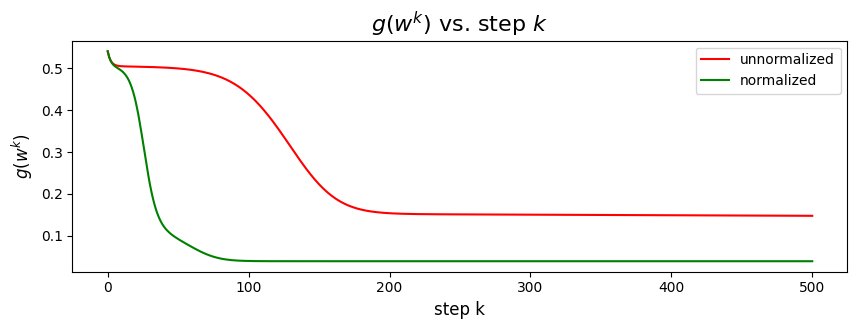

In [32]:
plt.figure(figsize=(10,3))
plt.plot(range(0,max_its+1), cost_history_1, 'r-', label = 'unnormalized')
plt.plot(range(0,max_its+1), cost_history_2, 'g-',  label = 'normalized')
plt.title(r'$g(w^k)$ vs. step $k$', fontsize=16)
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.legend()
plt.show()

#### <span style="color:#a50e3e;">Example. </span> Using an unparameterized feature transformation to model a classic physics dataset

In [33]:
csvname = readDataPath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

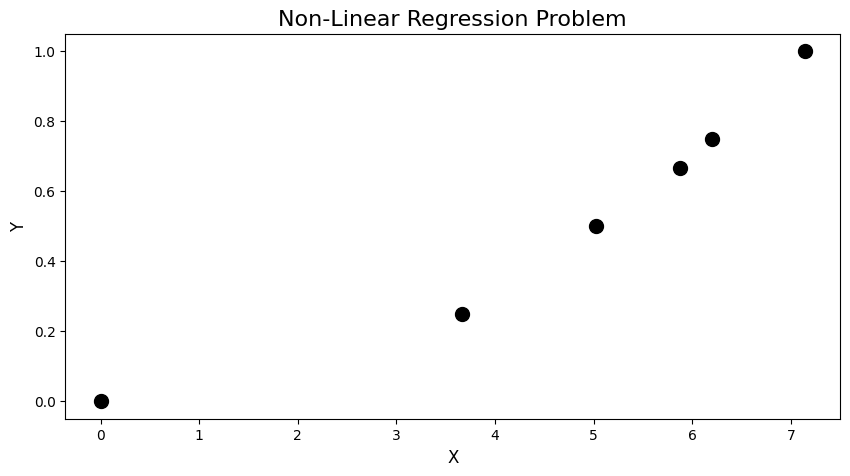

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression Problem', fontsize=16)
plt.show()

- The data here certainly displays a nonlinear relationship and by viewing it - and using his physical intuition Galileo - intuited a *quadratic* relationship.


- We can write the proposed model as In our jargon that for some $w_0$, $w_1$, and $w_2$ the modeling function 

\begin{equation}
\text{model}(x,\Theta) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

- Here we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$.

Notice here how we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\Theta) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

which clearly shows how we are seeking out a proper linear relationship in the transformed feature space (which in this case is two-dimensional).  Note here - unlike the previous examples - neither of these feature transformations are *fixed* in that they take in no internal weights.

In [35]:
def model(x,w,sig):   
    f = 0
    if len(sig.parameters) == 2:
        f = feature_transforms(x,w[0])
    else: 
        f = feature_transforms(x)    
    a = 0
    if len(sig.parameters) == 2:
        a = w[1][0] + np.dot(f.T,w[1][1:])
    else:
        a = w[0] + np.dot(f.T,w[1:])
    return a.T

In [36]:
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

In [37]:
np.random.seed(0)
w = 0.1*np.random.randn(3,1);
max_its = 50; alpha_choice = 10**(-1);

In [38]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

In [39]:
g = least_squares

In [40]:
sig = signature(feature_transforms)

In [41]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, sig)

In [42]:
ind = np.argmin(cost_history)
w_best = weight_history[ind]

In [43]:
view = [25,100]

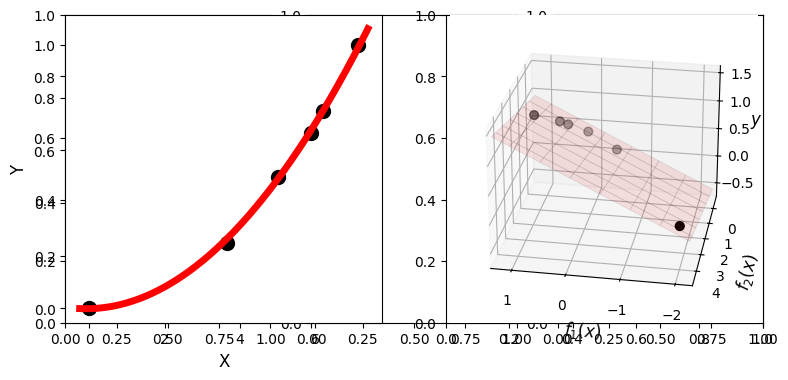

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(9,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 
ax1.scatter(x,y,s=100,facecolors='k', edgecolors='k')
ax1.set_xlabel('X', fontsize = 12)
ax1.set_ylabel('Y', fontsize = 12)

xmin = min(x[0]-0.25); xmax = max(x[0])+0.25;

x_line = np.linspace(xmin,xmax,1000).reshape((1,1000))

y_line = model(normalizer(x_line),w_best, sig)
ax1.plot(x_line[0],y_line[0],'r-',linewidth=5)

ax2 = plt.subplot(gs[1],projection = '3d');
s = np.linspace(xmin,xmax,100)[np.newaxis,:] 

s2 = copy.deepcopy(s)
s2 = feature_transforms(normalizer(s))

# reshape for plotting
a = s2[0,:]
b = s2[1,:]
x_transformed = feature_transforms(normalizer(x))
xmin1 = -0.76; xmax1 = 4.73;
xmin = min(x_transformed[0]-0.25); xmax = max(x_transformed[0])+0.25;
a = np.linspace(xmin,xmax,100)
b = np.linspace(xmin1,xmax1,100)
a,b = np.meshgrid(a,b)

a.shape = (1,np.size(s)**2)
f1 = feature_transforms(normalizer(a))[0,:]

b.shape = (1,np.size(s)**2)
f2 = feature_transforms(normalizer(b))[1,:]

c = np.vstack((a,b))
o = np.ones((1,np.shape(c)[1]))
c = np.vstack((o,c))
r = (np.dot(c.T,w_best))

# various
a.shape = (np.size(s),np.size(s))
b.shape = (np.size(s),np.size(s))
r.shape = (np.size(s),np.size(s))
ax2.plot_surface(a,b,r,alpha = 0.1,color = 'red',rstride=15, cstride=15,linewidth=0.5,edgecolor = 'k')
ax2.set_xlim([np.min(a),np.max(a)])
ax2.set_ylim([np.min(b),np.max(b)])

ax2.scatter(x_transformed[0,:].flatten(),x_transformed[1,:].flatten(),y.flatten(),color = 'k',s = 40)

# label axes
#self.move_axis_left(ax2)
ax2.set_xlabel(r'$f_1(x)$', fontsize = 12,labelpad = 5)
ax2.set_ylabel(r'$f_2(x)$', rotation = 0,fontsize = 12,labelpad = 5)
ax2.set_zlabel(r'$y$', rotation = 0,fontsize = 12,labelpad = 0)

ax2.view_init(view[0],view[1])

plt.show()

## Nonlinear Two-Class Classification

###  Modeling principles

- Linear two-class classification uses the linear model 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} 
\end{equation}


- The linear decision boundary  - employing by default label values $y_p \in \left\{-1,+1\right\}$ - then lies precisely where $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}  = 0$

- And, label predictions are made as

\begin{equation}
y = \text{sign}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)
\end{equation}

- To tune the set of weights properly for a given dataset we must minimize a proper two-class classification cost function, e.g., the Softmax/Cross-Entropy cost given by

\begin{equation}
 g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P} \text{log}\left(1 + e^{-y_p  \mathring{\mathbf{x}}_{p}^T \mathbf{w}}\right)
\end{equation}

###  Modeling principles  of nonlinear two class classification

- While we previously employed a *linear* model in deriving linear two-class classification schemes in Chapter 6, we could have just as well use any *nonlinear* model of the general form 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

- Here $f_1,\,f_2,\,...\,f_B$ are nonlinear parameterized or unparameterized functions - or *feature transformations*

- Once again, $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Theta$ and must be tuned properly.


- We can express this nonlinear model - using the same compact notation introduced previously - as 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}
\end{equation}

- In complete analogy to the linear case, here our decision boundary consists of all inputs $\mathbf{x}$ where $\mathring{\mathbf{f}}_{\,}^T \mathbf{w} = 0$


- And, likewise predictions are made as

\begin{equation}
y = \text{sign}\left(\mathring{\mathbf{f}}_{\,}^T \mathbf{w}\right)
\end{equation}

- Likewise, to properly tune the parameters of $\Theta$ we must minimize a proper cost function with respect to it, e.g., the Softmax cost


\begin{equation}
 g\left(\Theta\right) = \frac{1}{P}\sum_{p=1}^{P} \text{log}\left(1 + e^{-y_p  \mathring{\mathbf{f}}_{p}^T \mathbf{w}}\right)
\end{equation}

### Feature engineering

#### <span style="color:#a50e3e;">Example.</span>  A one-dimensional example of nonlinear classification 

In discussing classification through the lens of logistic regression, we saw how linear classification can be thought of as a particular instance of nonlinear regression.

In particular how from this perspective we aim at fitting a curve (or surface in higher dimensions) that consists of a linear combination of our input shoved through the `tanh` function. 

For $N=1$ dimensional input this regression looks like

\begin{equation}
\text{tanh}\left(w_0^{\,} + {x}_p {w}_{1}^{\,}\right) \approx y_p.
\end{equation}

Here our `model` is the simple linear one

\begin{equation}
\text{model}(x,\mathbf{w}) =  w_0 +_{\,} x_{\,}w_1.
\end{equation}

- With classification this function defines the linear decision boundary - a single point in this instance - where $\text{model}(x,\mathbf{w}) = 0$.  After tuning our weights properly by e.g., minimizing the softmax cost function, this decision boundary provides us with predicted labels for every possible input.  

- In particular if $\text{model}(x,\mathbf{w}) > 0$ then $x$ assigned to $+1$ class, if $\text{model}(x,\mathbf{w}) < 0$ assigned to $-1$ class.

In [45]:
csvname = readDataPath + 'signed_projectile.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load in input/output data
x = data[:-1,:]
y = data[-1:,:]

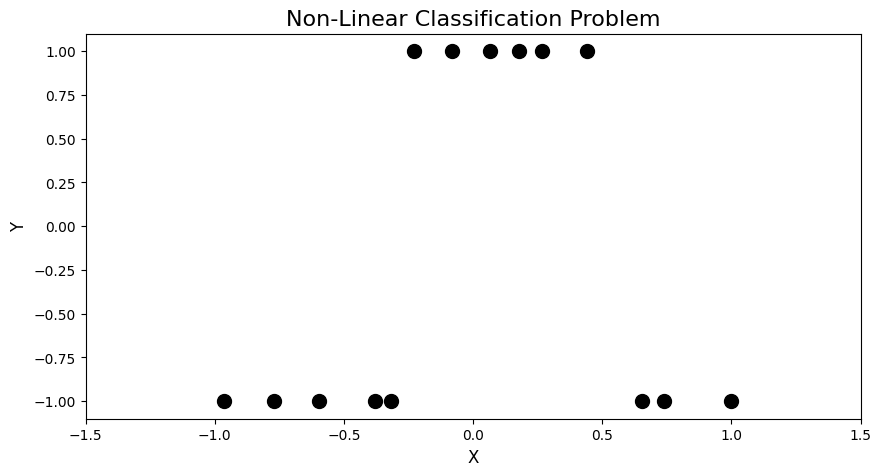

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.xlim(left=-1.5, right=1.5)
plt.show()

Using a generic quadratic function as our `model` takes the form

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + xw_1 + x^2w_2.
\end{equation}

Notice here how we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\Theta) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

where here the weight set $\Theta = \left\{\mathbf{w}\right\}$.

In [47]:
def model(x,w,sig):   
    f = 0
    if len(sig.parameters) == 2:
        f = feature_transforms(x,w[0])
    else: 
        f = feature_transforms(x)    
    a = 0
    if len(sig.parameters) == 2:
        a = w[1][0] + np.dot(f.T,w[1][1:])
    else:
        a = w[0] + np.dot(f.T,w[1:])
    return a.T

In [48]:
def softmax(w,x,y,sig):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w,sig))))
    return cost/float(np.size(y))

In [49]:
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

In [50]:
w = 0.1*np.random.randn(3,1); max_its = 500; alpha_choice = 10**(2)

In [51]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

g = softmax

sig = signature(feature_transforms)

In [52]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, sig)

In [53]:
ind = np.argmin(cost_history)
w_best = weight_history[ind]

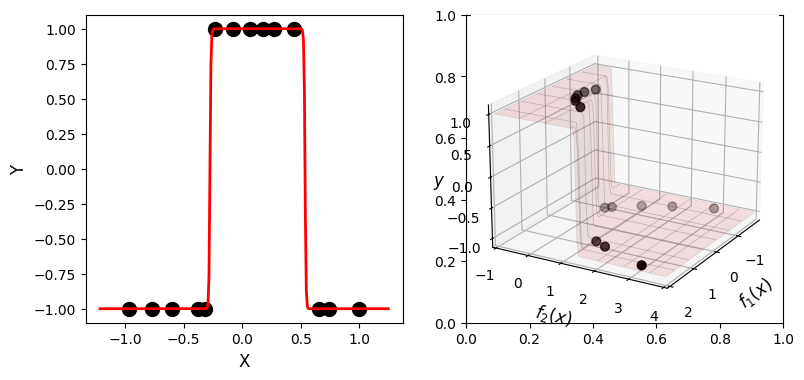

In [54]:
fig = plt.figure(figsize=(9,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 
view = [20,30]
ax1.scatter(x,y,s=100,facecolors='k', edgecolors='k')
ax1.set_xlabel('X', fontsize = 12)
ax1.set_ylabel('Y', fontsize = 12)
xmin = min(x[0]-0.25); xmax = max(x[0])+0.25;
s = np.linspace(xmin,xmax,300)[np.newaxis,:]
t = np.tanh(model(normalizer(s),w_best,sig))
ax1.plot(s.flatten(),t.flatten(),linewidth = 2,c = 'red')
x_transformed = feature_transforms(normalizer(x))
ax2 = plt.subplot(gs[1],projection = '3d');
s = np.linspace(xmin,xmax,100)[np.newaxis,:]
xmin1 = -1; xmax1 = 4;
xmin = min(x_transformed[0]-0.25); xmax = max(x_transformed[0])+0.25;
s2 = copy.deepcopy(s)
s2 = feature_transforms(normalizer(s))
a = s2[0,:]
b = s2[1,:]
a = np.linspace(xmin,xmax,100)
b = np.linspace(xmin1,xmax1,100)
a,b = np.meshgrid(a,b)
a.shape = (1,np.size(s)**2)
f1 = feature_transforms(normalizer(a))[0,:]
b.shape = (1,np.size(s)**2)
f2 = feature_transforms(normalizer(b))[1,:]
c = np.vstack((a,b))
o = np.ones((1,np.shape(c)[1]))
c = np.vstack((o,c))
r = np.tanh(np.dot(c.T,w_best))
a.shape = (np.size(s),np.size(s))
b.shape = (np.size(s),np.size(s))
r.shape = (np.size(s),np.size(s))
ax2.plot_surface(a,b,r,alpha = 0.1,color = 'red',rstride=15, cstride=15,linewidth=0.5,edgecolor = 'k')
ax2.set_xlim([np.min(a),np.max(a)])
ax2.set_ylim([np.min(b),np.max(b)])
ax2.set_xlabel(r'$f_1(x)$', fontsize = 12,labelpad = 5)
ax2.set_ylabel(r'$f_2(x)$', rotation = 0,fontsize = 12,labelpad = 5)
ax2.set_zlabel(r'$y$', rotation = 0,fontsize = 12,labelpad = 0)
ax2.view_init(view[0],view[1])
ax2.scatter(x_transformed[0,:].flatten(),x_transformed[1,:].flatten(),y.flatten(),color = 'k',s = 40)
plt.show()

#### <span style="color:#a50e3e;">Example. </span> Finding an elliptical boundary separating two classes

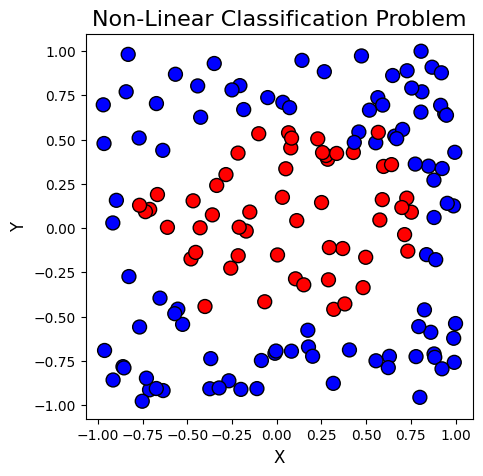

In [55]:
dataFileName = readDataPath + 'ellipse_2class_data.csv'
data = np.loadtxt(dataFileName,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]
data_plot = pd.DataFrame(data)
data_plot = data_plot.T
data_plot.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data_plot["Label"]==1,'r','b')
plt.scatter(data_plot["X"],data_plot["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

- Visually examining the dataset it appears that some sort of elliptical decision boundary centered at the origin might do a fine job of classification.

- Thus we set our `model` function to the general parameterized form of such an ellipse   

\begin{equation}
\text{model}(\mathbf{x},\Theta) = w_0^{\,} + x_1^2w_1^{\,} + x_2^2w_2^{\,}
\end{equation}

- Parsing this formula, we can see that we have used two feature transformations $f_1(\mathbf{x})=x_1^2$, $f_2(\mathbf{x}) = x_2^2$, and the parameter set $\Theta = \left\{w_0,\,w_1,\,w_2\right\}$.

In [56]:
def feature_transforms(x):
    # calculate feature transform
    f = x**2  
    return f

In [57]:
w = 0.1*np.random.randn(3,1); max_its = 1000; alpha_choice = 10**(0)

In [58]:
g = softmax

sig = signature(feature_transforms)

In [59]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,x,y, sig)

In [60]:
ind = np.argmin(cost_history)
w_best = weight_history[ind]

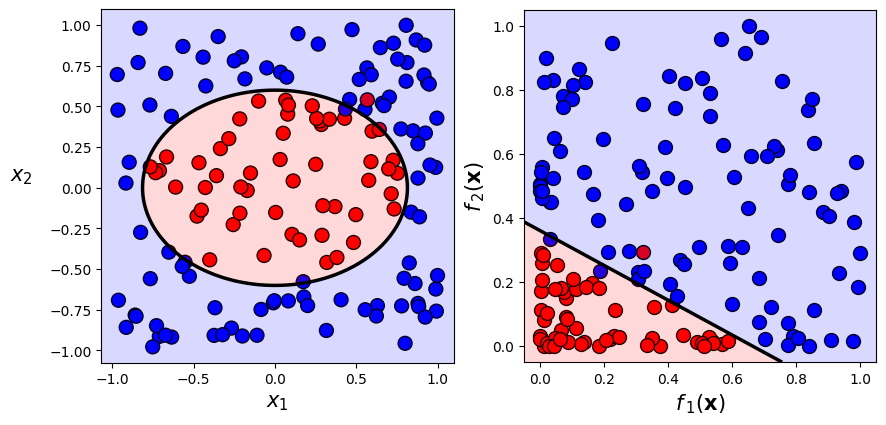

In [61]:
fig = plt.figure(figsize = (10,9))
gs = gridspec.GridSpec(1, 2,width_ratios = [1,1]) 
ax = plt.subplot(gs[0],aspect = 'equal');
ax2 = plt.subplot(gs[1],aspect = 'equal');

### cleanup left plots, create max view ranges ###
xmin1 = np.min(x[0,:]); xmin2 = np.min(x[1,:])
xmax1 = np.max(x[0,:]); xmax2 = np.max(x[1,:])
xgap1 = (xmax1 - xmin1)*0.05; xgap2 = (xmax2 - xmin2)*0.05
xmin1 -= xgap1; xmin2 -= xgap2
xmax1 += xgap1; xmax2 += xgap2

ax.set_xlabel(r'$x_1$',fontsize = 15)
ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0,labelpad = 20)
    
ind0 = np.argwhere(y == +1)
ind1 = np.argwhere(y == -1)

ax.scatter(data_plot["X"],data_plot["Y"],s=100,c=col, edgecolors='k')

# plot boundary for 2d plot
r1 = np.linspace(xmin1,xmax1,100); r2 = np.linspace(xmin2,xmax2,100)
s,t = np.meshgrid(r1,r2)
s = np.reshape(s,(np.size(s),1)); t = np.reshape(t,(np.size(t),1))
h = np.concatenate((s,t),axis = 1)
z = model(h.T,w_best,sig)
z = np.tanh(z)

# reshape it
s.shape = (np.size(r1),np.size(r2))
t.shape = (np.size(r1),np.size(r2))     
z.shape = (np.size(r1),np.size(r2))

ax.contour(s,t,z,colors='k', linewidths=2.5,levels = [0],zorder = 2)
cmap = colors.ListedColormap(['blue', 'red'])
ax.contourf(s,t,z,cmap=cmap, alpha = 0.15,levels = range(-1,2))

f = feature_transforms(x)

x1 = f[0,:]
x2 = f[1,:]
ind0 = [v[1] for v in ind0]
ind1 = [v[1] for v in ind1]

ax2.scatter(x1[ind0], x2[ind0], s=100,c='r', edgecolors='k')
ax2.scatter(x1[ind1], x2[ind1], s=100,c='b', edgecolors='k')

xmin1 = np.min(x1); xmax1 = np.max(x1)
xgap1 = (xmax1 - xmin1)*0.05
xmin1 -= xgap1; xmax1 += xgap1

xmin2 = np.min(x2); xmax2 = np.max(x2)
xgap2 = (xmax2 - xmin2)*0.05
xmin2 -= xgap2; xmax2 += xgap2

ax2.set_xlabel(r'$f\,_1\left(\mathbf{x}\right)$',fontsize = 15)
ax2.set_ylabel(r'$f\,_2\left(\mathbf{x}\right)$',fontsize = 15)        

r1 = np.linspace(xmin1,xmax1,100); r2 = np.linspace(xmin2,xmax2,100)
s,t = np.meshgrid(r1,r2)

s.shape = (1,len(r1)**2); t.shape = (1,len(r2)**2)
z = w_best[0] + w_best[1]*s + w_best[2]*t
z = np.tanh(np.asarray(z))

s.shape = (np.size(r1),np.size(r2)); t.shape = (np.size(r1),np.size(r2)); z.shape = (np.size(r1),np.size(r2))

ax2.contour(s,t,z,colors='k', linewidths=2.5,levels = [0],zorder = 2)
ax2.contourf(s,t,z,cmap=cmap,alpha = 0.15,levels = range(-1,2))
plt.show()